Метод k-means – это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.

<h2>Кластеризация игроков NBA</h2>

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

nba = pd.read_csv("nba_2013.csv")
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


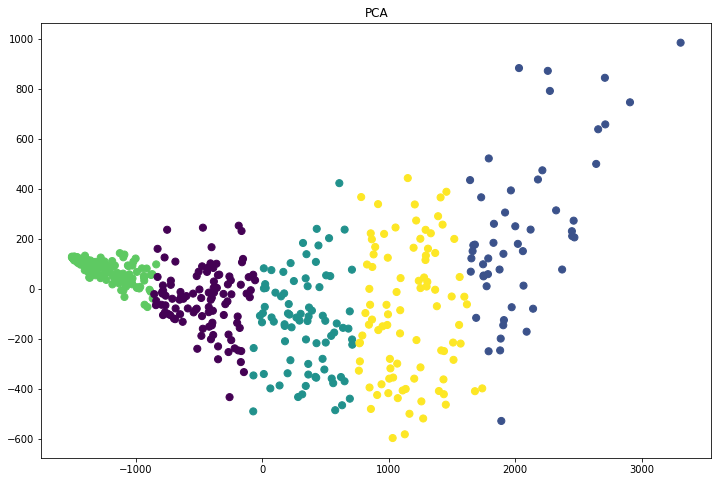

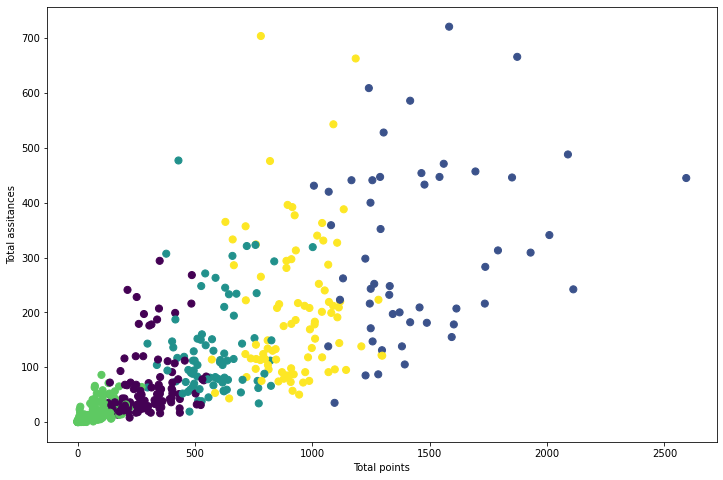

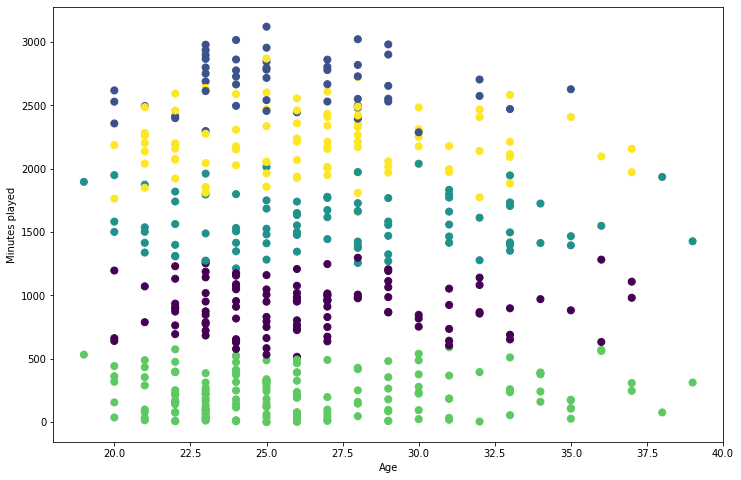

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# n_clusters=5 - количество формирующихся кластеров
kmeans = KMeans(n_clusters=5, random_state=1)

# Удаляем все нечисловые значения
# nba._get_numeric_data() - фильтрация только числовых столбцов
# dropna(axis=1) - удаляет пропущенные столбцы (в данном случае все нечисловые)
numeric_cols = nba._get_numeric_data().dropna(axis=1)
kmeans.fit(numeric_cols)


# Визуализация данных по главным компонентам (PCA)
# n_components=2 - количество компонентов
pca = PCA(n_components=2)
res = pca.fit_transform(numeric_cols)
plt.figure(figsize=(12,8))

# scatter - диаграмма рассеивания
# res[:,0], res[:,1] - координаты x, y
# c=kmeans.labels_ - определяем цвета (в данном случае для каждого из 5-ти кластеров выводим свой цвет)
# s=50 - размер маркера
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.title('PCA')

# Визуализация с помощью 2-х признаков: Total points vs. Total assists
# При этом цвета маркеров делим по кластерам
plt.figure(figsize=(12,8))
plt.scatter(nba['pts'], nba['ast'], c=kmeans.labels_, s=50, cmap='viridis')
plt.xlabel('Total points')
plt.ylabel('Total assitances')

# Визуализация с помощью 2-х признаков: Age vs. Minutes played
plt.figure(figsize=(12,8))
plt.scatter(nba['age'], nba['mp'], c=kmeans.labels_, s=50, cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Minutes played');

<h2>Сжатие изображений с K-means</h2>

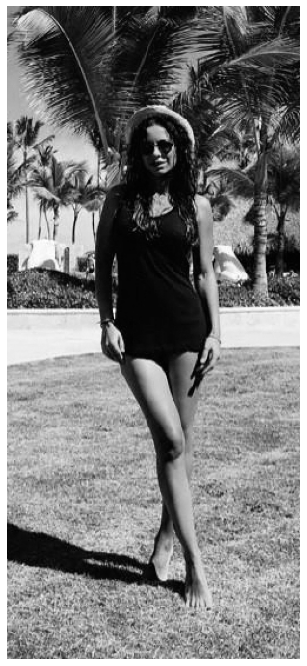

In [14]:
import matplotlib.image as mpimg
img = mpimg.imread('woman.jpg')[..., 1]
plt.figure(figsize = (20, 12))
plt.axis('off')
# cmap='gray' - сопоставление цветов (цвета переходят в оттенки серого)
plt.imshow(img, cmap='gray');

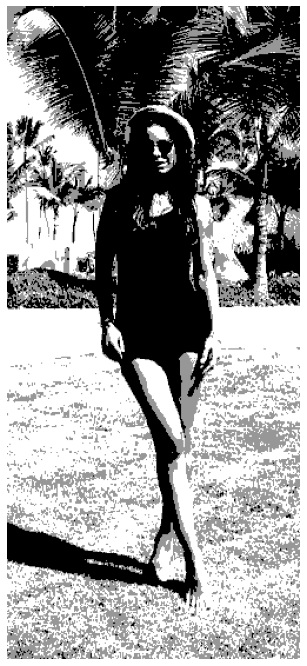

In [16]:
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import randint

X = img.reshape((-1, 1))
# Кластеризуем цвета до 3-х кластеров
k_means = MiniBatchKMeans(n_clusters=3)
k_means.fit(X) 

# Находим центры кластеров - это 3 цвета
values = k_means.cluster_centers_
# labels_ - метки каждой точки
labels = k_means.labels_
# values[labels] - для каждой метки указываем свой цвет
# reshape - придает новую форму массиву без изменения данных
img_compressed = values[labels].reshape(img.shape)
plt.figure(figsize = (20, 12))
plt.axis('off')
plt.imshow(img_compressed, cmap = 'gray');

<h2>Нахождение тем в текстах</h2>

Кластеризации текстов из 4 новостных категорий

In [21]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from time import time

categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space']

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

labels = dataset.target
true_k = np.unique(labels).shape[0]

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories


In [24]:
print("Extracting features from the training dataset using a sparse vectorizer")
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english')

X = vectorizer.fit_transform(dataset.data)
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
n_samples: 3387, n_features: 1000


Закодируем тексты с помощью TF-IDF признаков

Применим к получившимся векторам метод k средних

In [26]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
Homogeneity: 0.337
Completeness: 0.451
V-measure: 0.386
Adjusted Rand-Index: 0.289
Silhouette Coefficient: 0.013


In [29]:
# Выведем слова, соответствующие самым весомым компонентам центров кластеров
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % (i + 1), end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 1: keith com sgi livesey morality caltech objective article moral say
Cluster 2: access digex pat prb net hst online communications com usa
Cluster 3: space com university graphics posting host nntp nasa like article
Cluster 4: god sandvik jesus com people kent christian bible koresh apple


<h2>Кластеризация рукописных цифр</h2>

In [30]:
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target

In [31]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [32]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y, kmeans.predict(X))

0.6672744809463086

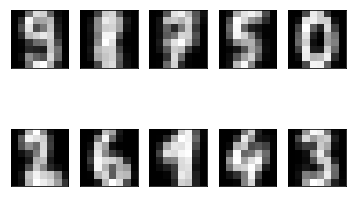

In [33]:
_, axes = plt.subplots(2, 5)
for ax, center in zip(axes.ravel(), kmeans.cluster_centers_):
    ax.matshow(center.reshape(8, 8), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())